## Costs



### Preface



There are a few modules you may need to install (but avoid this if you can; you may need to restart your kernel afterwards):



In [3]:
!pip install -r requirements.txt

  Using cached CFEDemands-0.5.4-py2.py3-none-any.whl (47 kB)
  Using cached gspread-5.8.0-py3-none-any.whl (40 kB)
  Using cached gspread_pandas-3.2.2-py2.py3-none-any.whl (26 kB)
  Using cached oauth2client-4.1.3-py2.py3-none-any.whl (98 kB)
  Using cached eep153_tools-0.11-py2.py3-none-any.whl (4.4 kB)
  Using cached python_gnupg-0.5.0-py2.py3-none-any.whl (18 kB)
  Using cached ConsumerDemands-0.4.1.dev0-py2.py3-none-any.whl (12 kB)
  Using cached xarray-2023.4.2-py3-none-any.whl (979 kB)
  Using cached pandas-2.0.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached ray-2.4.0-cp39-cp39-manylinux2014_x86_64.whl (58.6 MB)
  Using cached dvc-2.55.0-py3-none-any.whl (419 kB)
  Using cached iterative_telemetry-0.0.8-py3-none-any.whl (10 kB)
  Using cached zc.lockfile-3.0.post1-py3-none-any.whl (9.8 kB)
  Using cached dvc_render-0.3.1-py3-none-any.whl (18 kB)
  Using cached dvc_task-0.2.1-py3-none-any.whl

  Using cached dictdiffer-0.9.0-py2.py3-none-any.whl (16 kB)
  Using cached nanotime-0.5.2-py3-none-any.whl
  Using cached dvc_objects-0.21.2-py3-none-any.whl (37 kB)
  Using cached attrs-23.1.0-py3-none-any.whl (61 kB)
  Using cached sqltrie-0.3.1-py3-none-any.whl (16 kB)
  Using cached diskcache-5.6.1-py3-none-any.whl (45 kB)
  Using cached aiohttp_retry-2.8.3-py3-none-any.whl (9.8 kB)
  Using cached dulwich-0.21.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (505 kB)
  Using cached celery-5.2.7-py3-none-any.whl (405 kB)
  Using cached kombu-5.2.4-py3-none-any.whl (189 kB)
  Using cached atpublic-3.1.1-py3-none-any.whl (4.8 kB)
  Using cached antlr4_python3_runtime-4.9.3-py3-none-any.whl
  Using cached omegaconf-2.3.0-py3-none-any.whl (79 kB)
  Using cached asyncssh-2.13.1-py3-none-any.whl (348 kB)
  Using cached GitPython-3.1.31-py3-none-any.whl (184 kB)
  Using cached pygit2-1.12.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.9 MB)
  Using cached billiard

  Using cached smmap-5.0.0-py3-none-any.whl (24 kB)
  Attempting uninstall: pytz
    Found existing installation: pytz 2021.1
    Uninstalling pytz-2021.1:
      Successfully uninstalled pytz-2021.1
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.62.1
    Uninstalling tqdm-4.62.1:
      Successfully uninstalled tqdm-4.62.1
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.0
    Uninstalling python-dateutil-2.8.0:
      Successfully uninstalled python-dateutil-2.8.0
  Attempting uninstall: pathspec
    Found existing installation: pathspec 0.9.0
    Uninstalling pathspec-0.9.0:
      Successfully uninstalled pathspec-0.9.0
  Attempting uninstall: joblib
    Found existing installation: joblib 1.0.1
    Uninstalling joblib-1.0.1:
      Successfully uninstalled joblib-1.0.1
  Attempting uninstall: attrs
    Found existing installation: attrs 19.3.0
    Uninstalling attrs-19.3.0:
      Successfully uninstalled attrs-19.3.0
  A

### Data



We&rsquo;ll get data from two places.  First, basic data, including a food
 conversion table and recommended daily intakes table can be found in
 a google spreadsheet.

Here are addresses of google sheets for different dataframes for the
case of Uganda:



In [4]:
InputFiles = {'FCT':('13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo','FCT'),
              'RDI':('13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo','RDI'),}

#### Prices, FCT, RDI



In [5]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) #####################
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


In [6]:
import pyarrow.parquet as pq

# Get prices 
p = pq.read_table(source='ap68_prices.parquet').to_pandas()
p.reset_index(level='unit', drop=True, inplace=True)

#### Pre-estimated Demand Systems



An instance `r` of `cfe.Regression` can be made persistent with
 `r.to_pickle('my_result.pickle')`, which saves the instance &ldquo;on disk&rdquo;, and can be loaded using `cfe.regression.read_pickle`.  We use  this method below to load data and demand system previously estimated for Uganda:



In [7]:
import cfe.regression as rgsn

r = rgsn.read_pickle('ap68.pickle')  # Assumes you've already set this up e.g., in Project 3

Missing dependencies for OracleDemands.


### Ceteris Paribus



We begin by setting up some benchmarks for prices and budgets, so
    the things we don&rsquo;t want to change we can hold fixed.



#### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [8]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p # Prof Ligon provided what are presumably already average prices 
pbar = pbar.loc[r.beta.index] # Only use prices for goods we can estimate
pbar = pbar.iloc[:,0]

#### Budgets



Get food budget for all households, then find median budget:



In [9]:
import numpy as np

xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
x0 = xbar.quantile(0.5)  # Household at 0.5 quantile is median

#### Changing one price, holding others fixed



Finally, define a function to change a single price in the vector $p$:



In [10]:
def my_prices(p0,p=pbar,j='tomato'):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

### Simple Policy Experiments: Changing Prices



If price of a good increases/decreases, what&rsquo;s the cost to the
household?  Ask a related question: If a price $p_1$ increases, how
much *income* do we need to give to the household to make it just as
well off as it was at the old prices?

Summarize this as the  *compensating variation* associated with the
price change.

![img](./compensating_variation.png)

Compensating Variation can also be measured as the (change in the)
area under the **Hicksian** (or **compensated**) demand curve:

![img](./compensating_variation_newexpenditure.png).



#### Marshallian vs. Hicksian Demand Curves



Let&rsquo;s look at Marshallian & Hicksian demands&#x2014;one way of thinking
about the Hicksian (compensated) curves is that they  eliminate the
income effect associated with changing prices.



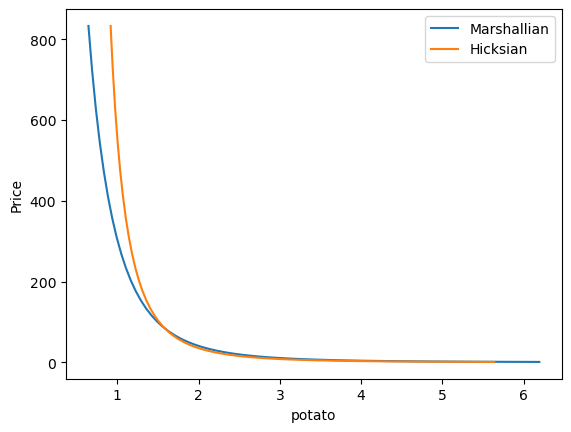

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

my_j = 'potato'  # Interesting [REGION] staple

P = np.geomspace(.01,10,50)*pbar[my_j]

# Utility of median household, given prices
U0 = r.indirect_utility(x0,pbar)

plt.plot([r.demands(x0,my_prices(p0,j=my_j))[my_j] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(p0,j=my_j),type="Hicksian")[my_j] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(my_j)
plt.legend(("Marshallian","Hicksian"))

#### Welfare measures



In [12]:
def compensating_variation(U0,p0,p1):
    x0 = r.expenditure(U0,p0)
    x1 = r.expenditure(U0,p1)

    return x1-x0

def revenue(U0,p0,p1,type='Marshallian'):
    """(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    
    dp = p1 - p0 # Change in prices

    c = r.demands(U0,p1,type=type)

    dp,c = dp.align(c,join='inner')

    return dp.T@c


def deadweight_loss(U0,p0,p1):
    """
    Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    cv = compensating_variation(U0,p0,p1)

    return cv - revenue(U0,p0,p1,type='Hicksian')

#### Price Changes, Revenue, and Compensating Variation



Examine effects of price changes on revenue (if price change due to a
tax or subsidy) and compensating variation.



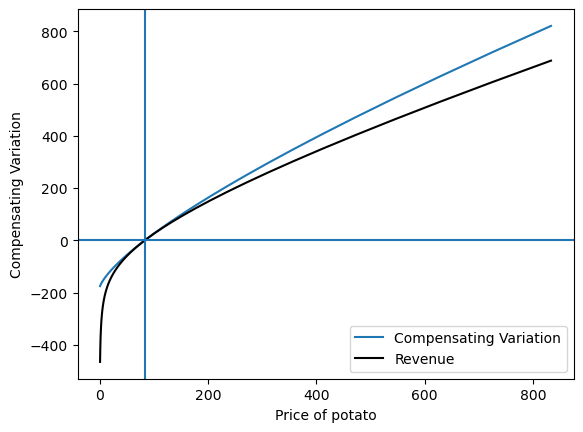

In [16]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,pbar,my_prices(p0,j=my_j)) for p0 in P])
ax1.set_xlabel(f"Price of {my_j}")
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,pbar,my_prices(p0,j=my_j),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(pbar.loc[my_j])

#### Deadweight Loss



Differences between revenue and compensating variation is deadweight-loss:



Text(0, 0.5, 'Deadweight Loss')

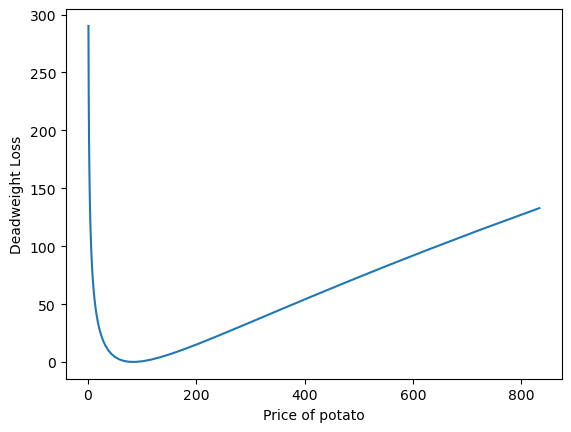

In [17]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,pbar,my_prices(p0,j=my_j)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_j)
ax1.set_ylabel("Deadweight Loss")